<a href="https://colab.research.google.com/github/catavasia/ML_FIAN-21/blob/main/seminar05_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [1]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
import sklearn.metrics as skmetrics

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [83]:
(y[:,np.newaxis] - y.mean()).shape

(100, 1)

In [7]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)

    # plt.figure(figsize=(10, 8))
    # plt.hist(covariance)
    # plt.xlabel('Covarience', fontsize=40)
    # plt.ylabel('N', size=40)     
    # plt.rc('xtick', labelsize=30)
    # plt.rc('ytick', labelsize=30)

    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

    # plt.figure(figsize=(10, 8))
    # plt.hist(covariance[-self.n:])
    # plt.xlabel('Covarience', fontsize=40)
    # plt.ylabel('N', size=40)     



  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [78]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

In [71]:
X[:10].shape

(10, 1000)

# Посмотрим, как распределены признаки(спойлер:нормально)

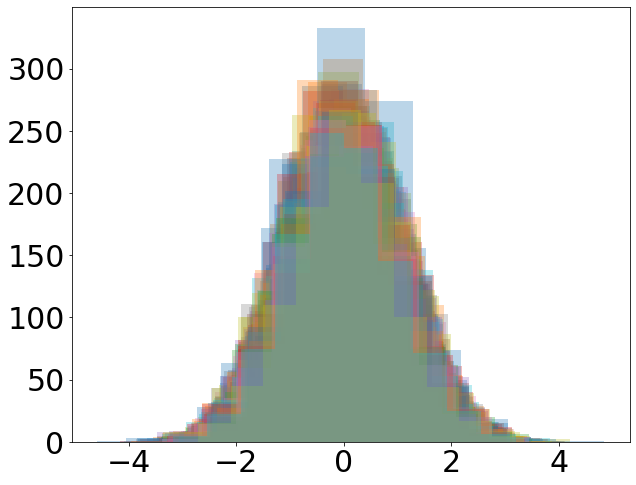

In [37]:
plt.figure(figsize=(10,8))
for i in range(0, N):
  plt.hist(X[i], alpha=0.3)

In [75]:
# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Как распределены лучшие признаки

(array([50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 50.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

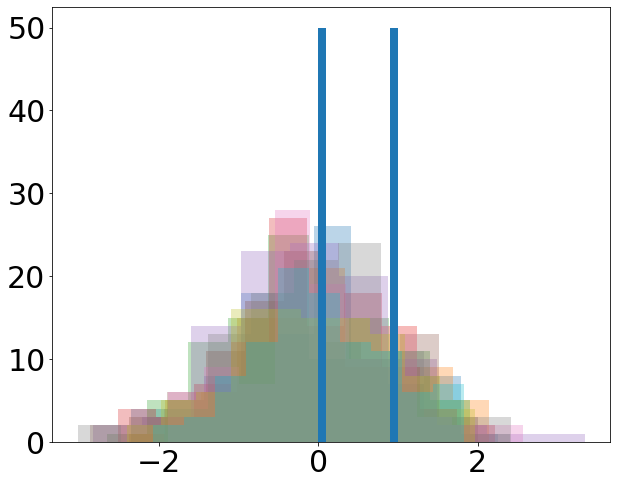

In [38]:
plt.figure(figsize=(10,8))
for i in range(0, 10):
  plt.hist(X_best[i], alpha=0.3)
plt.hist(y)

In [76]:
# Simple classification model
model = LinearSVC()
model.fit(X_best, y)
y_pred = model.predict(X_best)
print(f'score: {skmetrics.accuracy_score(y, y_pred)}')

# Estimating accuracy using cross-validation:
score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1)
print(f"score {score}")
cv_score = score.mean()
print(f"CV score is {cv_score}")

score: 0.85
score [0.7 0.8 0.5 0.8 0.8 0.8 0.9 0.7 0.8 0.8]
CV score is 0.76


In [51]:

# Simple classification model
model = LinearSVC()
model.fit(X_best, y)
y_pred = model.predict(X_best)
print(f'score: {skmetrics.accuracy_score(y, y_pred)}')

# Estimating accuracy using cross-validation:
score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1)
print(f"score {score}")
cv_score = score.mean()
print(f"CV score is {cv_score}")

score: 1.0
score [0.9 1.  0.9 1.  0.8 0.9 1.  0.8 0.9 1. ]
CV score is 0.9199999999999999


# Линейная регрессия на лучших признаках

0.68


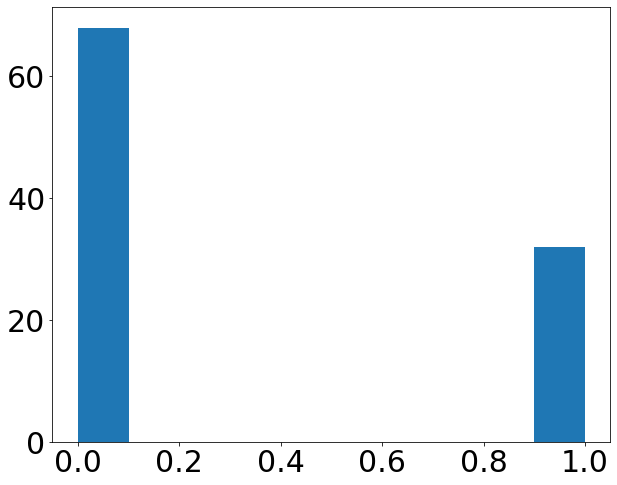

In [50]:
model = LinearRegression()
model.fit(X_best, y)
preds = model.predict(X_best)
plt.figure(figsize=(10,8))
plt.hist(np.abs(y - y_pred))
y_pred = np.where(preds < 1, 0, 1)
print(skmetrics.accuracy_score(y, y_pred))

What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

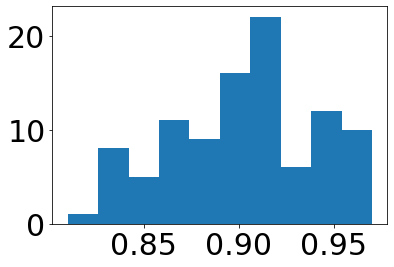

In [52]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

# Попытка объяснения проблемы

Я думаю, что проблема заключается в том, что мы изначально отбираем лучшие признаки, рассмотрев ковариацию между ними.

**Ковариация** - мера линейной зависимости двух случайных величин. 



Вектор весов выражается через объекты и метки классов следующим образом(выражение из лекций):

$$ \quad \boldsymbol w = \sum\limits_{i=1}^n \lambda_i y_i x_i $$

Мы выбрали признаки объектов таким образом, что метки классов линейно от них зависят. Если ковариация признак-метка большая, то $$\lambda_i $$ 
будет уменьшаться в силу того, что мы минимизируем следующий функционал:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
\end{gather}
$$
И тогда данный объект будет являться опорным для построения разделяющей гиперплоскости. А он линейно зависим с меткой класса. 

Посмотрим на результаты моделей, обученных на первых 100 признаках и всех признаках.  

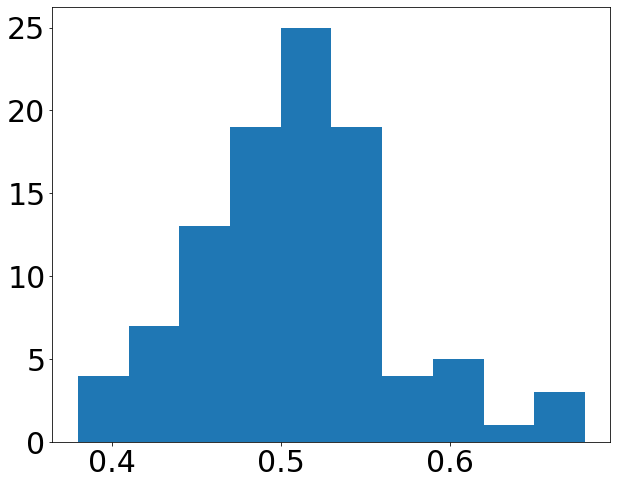

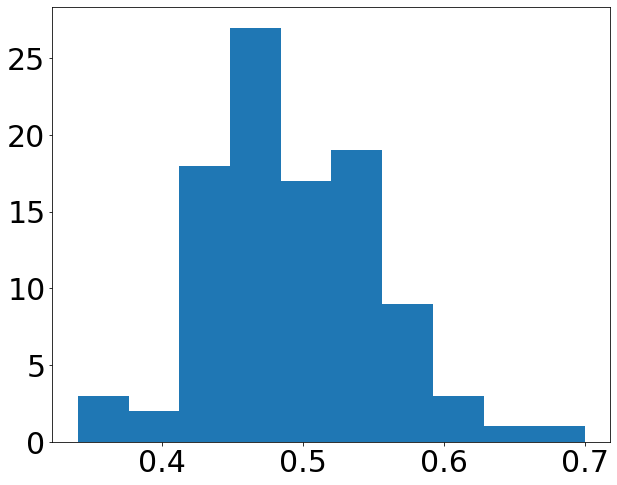

In [67]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment(N_features):
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  #X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X[:,:N_features+1], y, scoring='accuracy', cv=10, n_jobs=-1).mean()

plt.figure(figsize=(10,8))
results = [experiment(100) for _ in range(100)]
plt.hist(results, bins=10);

plt.figure(figsize=(10,8))
results = [experiment(1000) for _ in range(100)]
plt.hist(results, bins=10);

# Наблюдение

Видно, что теперь accuracy примерно 50 %, чего и требовалось ожидать.